In [1]:
import pathlib
import pickle
import platform
import warnings

import numpy as np
import pandas as pd
import pymc3 as pm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as MAE
from theano import shared

import arviz as ar
from matplotlib import cm
import matplotlib.pyplot as pl
from matplotlib import rcParams

In [2]:
ar.style.use('arviz-darkgrid')
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['font.size'] = 16
rcParams['legend.fontsize'] = 16

In [3]:
warnings.filterwarnings('ignore', category=FutureWarning)

### <u>Package Versions<u>

In [4]:
def pkg_ver(pkgs):
    print('Python & Package Versions')
    print('----------------')
    print(f'PYTHON: {platform.python_version()}')
    for pki in pkgs:
        print(f'{pki.__name__}: {pki.__version__}')
pkg_ver([np, pd, pm, ar])

Python & Package Versions
----------------
PYTHON: 3.7.3
numpy: 1.17.3
pandas: 0.25.0
pymc3: 3.7
arviz: 0.5.1


<a id="TOP"/>

---
## <u>Notebook Content</u>

The notebook flow is as follows:
* Overview
* [Data Steps](#Data)
    * Loading
    * Train/Test Split
    * Standardization
* [Model 1: Linear Regression with Maximum Blue-to-Green Band Ratio (MBR) as Input](#Model1)
    * Model Development
    * Prior Predictive Simulation for Assessment of Priors 
    * Model Fitting & Posterior Evaluation
* [Model 2: Hierarchical Linear Regression with MBR as input and Blue Band-Based Grouping](#Model2)
    * Model Development
    * Prior Predictive Simulation for Assessment of Priors 
    * Model Fitting & Posterior Evaluation
* [Model 3: MBR-Based Fourth Order Polynomial Regression](#Model3)
    * Model Development
    * Prior Predictive Simulation for Assessment of Priors 
    * Model Fitting & Posterior Evaluation
* [Model 4: PCA-Based Linear Regression](#Model4)
    * Model Development
    * Prior Predictive Simulation for Assessment of Priors 
    * Model Fitting & Posterior Evaluation
* [Model Comparison](#ModelComp)
    * Information Criteria Based Comparison (WAIC)
    * Estimated Leave-One-Out Cross Validation (PSIS-LOOCV)
    * Model Performance on Out-of-Sample Test Data Set

--- 
## <u>Overview</u>

In this notebook, I implement bayesian regression models for chlorophyll prediction from satellite remote sensing data. Each implementation follows the sequence below.

* The model is cast in a Bayesian framework using a probabilistic programming language (PPL);
* A set of prior predictive simulations is conducted to ascertain that model priors are reasonable;
* The model is fit using the No U-Turn Sampler (NUTS) variant of Hamiltonian Monte Carlo, and the data subset from NOMAD 2008;
* Model predictive skill and  uncertainty are quantified via posterior distribution evaluation and posterior predictive simulation.
* The skill of these models are inter-compared using Information Criteria (IC) based methods. These include Watanabe Akaike Information Criterion (WAIC) and/or Pareto Smoothed Importance Sampling Leave-One-Out Cross Validation (LOO).

### The Models in the Notebooks
<br>
I include 4 models listed below and for which \\(log(chl)\\):

1. A linear regression model, with $$MBR=\frac{max(log(Rrs443), log(Rrs489), log(Rrs510))}{log(Rrs555)}$$

2. A hierarchical, partially pooled \\(MBR\\) model, where the data is grouped by the blue band of the \\(MBR\\) numerator.
3. An OC4-type \\(4^{th}\\)degree polynomial regression such that
$$log(chl) = \alpha + \sum^4_{i=1}\beta_i  (MBR)^i$$
4. A simple linear regression where the inputs are the principal components derived from the PCA of Rrs bands.

<a id='Data'/>

---
## <u>Data Steps</u>
### Loading the Data
The data was stored previously in [pandas dataframes](https://pandas.pydata.org). Four types of dataset are used. For models 1-3 listed above, I used data developed in the notebook available [here](./Step-2-1-Feature-Engineering-Log-MBR-CI.ipynb), where MBR is pre-computed. These are split as training set used for the fitting, and testing for out-of-sample model evaluation (see [here](./Step-2-2-Feature-Engineering_PCA.ipynb#Split)). For model 4, listed above, I use pca data that originates from the same data as that used for the other model. The PCA steps are documented [here](./Step-2-2-Feature-Engineering_PCA.ipynb#split-pca). These data are similarly split into training and testing sets. However unlike the earlier batch, these were already standardized, and the full pre-processing pipeline was saved as shown in [the same notebook](./Step-2-2-Feature-Engineering_PCA.ipynb#split-pca).

---
<[Back to Index](#TOP)>

In [5]:
df = pd.read_pickle('./data/df_main_2_w_CI.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Data columns (total 26 columns):
id                4459 non-null int64
etopo2            4459 non-null float64
log_etopo2        4459 non-null float64
lat               4459 non-null float64
rrs411            4293 non-null float64
log_rrs411        4293 non-null float64
rrs443            4456 non-null float64
log_rrs443        4456 non-null float64
rrs489            4422 non-null float64
log_rrs489        4422 non-null float64
rrs510            3435 non-null float64
log_rrs510        3435 non-null float64
rrs555            3255 non-null float64
log_rrs555        3255 non-null float64
rrs670            1598 non-null float64
log_rrs670        1598 non-null float64
CI                1163 non-null float64
CI_OK             4459 non-null int64
MaxBlue           4459 non-null float64
MaxBlueBand       4459 non-null object
MaxBlueBandIdx    4459 non-null int8
mxBlue2Gr         3255 non-null float64
log_mxBlue2Gr     325

### Train/Test Split

Below, I load indices generated from a train/test split procedure with stratification by the blue band used in the numerator of MBR as shown [here](./Step-2-2-Feature-Engineering_PCA.ipynb#Split). This ensures both training and test sets are equally balanced.

In [6]:
with open('./data/train_test_indices.pkl' ,'rb') as fb:
    tt_pkl_d = pickle.load(fb)
    train_idx_no_nans = tt_pkl_d['train_idx_no_nans']
    test_idx_no_nans = tt_pkl_d['test_idx_no_nans']
    del tt_pkl_d

In [7]:
cols = ['log_mxBlue2Gr', 'MaxBlueBandIdx', 'log_chlor_a']
df_small_train = df.iloc[train_idx_no_nans][cols]
df_small_test = df.iloc[test_idx_no_nans][cols]

In [8]:
df_small_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 841 entries, 737 to 1475
Data columns (total 3 columns):
log_mxBlue2Gr     841 non-null float64
MaxBlueBandIdx    841 non-null int8
log_chlor_a       841 non-null float64
dtypes: float64(2), int8(1)
memory usage: 20.5 KB


In [9]:
df_small_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211 entries, 1182 to 3960
Data columns (total 3 columns):
log_mxBlue2Gr     211 non-null float64
MaxBlueBandIdx    211 non-null int8
log_chlor_a       211 non-null float64
dtypes: float64(2), int8(1)
memory usage: 5.2 KB


In [10]:
X_train = df_small_train.log_mxBlue2Gr.values
y_train = df_small_train.log_chlor_a.values

[Back to index](#TOP)

--- 

### Predictor and target standardization
<br>
\\(\rightarrow \\)data centered at 0 and scaled to have standard deviation of 1
<br>
\\(\rightarrow \\)makes models converge faster
<br>
\\(\rightarrow \\)Any parametric data transformation must be <u>based on training data</u> and...<br>
\\(\rightarrow \\)Applied <u>without alteration</u> to out-of-sample data

In [11]:
sc_x = StandardScaler()
sc_y = StandardScaler()
x_train_s = sc_x.fit_transform(X_train[:, None]).ravel()
y_train_s = sc_y.fit_transform(y_train[:, None]).ravel()

In [12]:
x_test_s = sc_x.transform(df_small_test.log_mxBlue2Gr.values[:, None]).ravel()
y_test_s = sc_y.transform(df_small_test.log_chlor_a.values[:, None]).ravel()

<a id='Model1'/>

---

## <u>Model 1: Linear Regression with Maximum Blue-to-Green Band Ratio (MBR) as Input</u>

### Model Development

In [13]:
with pm.Model() as mbr_linear_pooled:
    data = pm.Data('data', x_train_s)
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    σ = pm.Exponential('σ', 1)
    μ = α + β * data
    likelihood = pm.Normal('likelihood', mu=μ, sd=σ, observed=y_train_s)

In [14]:
mlp_graph = pm.model_to_graphviz(mbr_linear_pooled)
mlp_graph.render(filename='mdl1', directory='./resources', format='png');

<img src='./resources/mdl1.png?=2' />

### Assessing Priors with Prior Predictive Simulation


\\(\rightarrow\\)Interactive: Jump back and forth between model formulation and Prior Predictive<br>
\\(\rightarrow\\)Note of caution: Don't assign prior where reasonable values have probability 0

In [15]:
with mbr_linear_pooled:
    prior_mlp = pm.sample_prior_predictive()

In [16]:
def plot_data(x, y, **kwargs):
    ax = kwargs.pop('ax', None)
    c = kwargs.pop('c', [[1, 0, 0, 0.35]])
    edgecolor = kwargs.pop('edgecolor', 'k')
    label = kwargs.pop('label', 'true')
    zorder = kwargs.pop('zorder', 3)
    if ax:
        ax.scatter(x, y, c=c, edgecolor=edgecolor, 
               label=label, zorder=zorder)
    else:
        pl.scatter(x, y, c=c, edgecolor=edgecolor, 
               label=label, zorder=zorder)


def plot_priors(prior_, X_s, y_s, model_centric=True):
    x_idx = np.argsort(X_s)
    pl.title('Pooled Linear Model Prior Analysis')
    pl.scatter(X_s[x_idx], y_s[x_idx], c=[[1, 0, 0, 0.35]], 
               edgecolor='k', 
               label='true', 
               #alpha=0.65, 
               zorder=3
              )
    if model_centric:
        prior_realizations = np.dot(prior_['β'][:, None], X_s[None, :]) + prior_['α'][:, None]
        pl.plot(X_s[x_idx], prior_realizations[0, x_idx].T, color='k',
                alpha=0.1, label='prior model realizations')
        pl.plot(X_s[x_idx], prior_realizations[1:, x_idx].T, color='k',
                alpha=0.1,)
    else:
        mean_prior_y = prior_['likelihood'].mean(axis=0)
        hdi_prior_y = ar.hpd(prior_['likelihood'])
        pl.scatter(X_s[x_idx], mean_prior_y[x_idx], color='k',
               label='prediction mean', zorder=2)
        pl.fill_between(X_s[x_idx], hdi_prior_y[x_idx, 0], hdi_prior_y[x_idx, 1],
                       alpha=0.5, label='model prediction 94%HDI')
    pl.ylabel('log chl (standardized)')
    pl.xlabel('MBR (standardized)')
    pl.legend(loc='upper center');

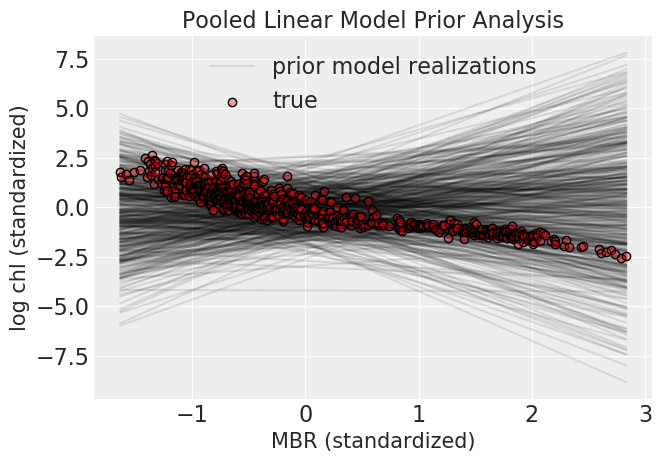

In [17]:
plot_priors(prior_mlp, x_train_s.ravel(), y_train_s.ravel())

### Model Fitting & Posterior Evaluation

In [38]:
n_samples=2000
with mbr_linear_pooled:
    trace_mlp = pm.sample(n_samples, tune=1000)
    post_mlp = pm.sample_posterior_predictive(trace_mlp)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β, α]
100%|██████████| 4000/4000 [00:03<00:00, 1022.79it/s]


In [40]:
def plot_posteriors_mv(post_, trace_, X_s, y_s, model_centric=True, num_pred=500):
    n_iters = n_samples * trace_.nchains
    x_idx = np.argsort(X_s)
    pl.title('Pooled Linear Model Posterior Analysis')
    #pl.scatter(X_s[x_idx], y_s[x_idx], c=[[1, 0, 0, 0.35]], edgecolor='k',
    #          label='true', alpha=0.65, zorder=3)
    plot_data(X_s[x_idx], y_s[x_idx])
    if model_centric:
        realization_idcs = np.random.choice(np.arange(1, n_iters, dtype='int'), 
                                            size=500, replace=False)
        post_realizations = np.dot(X_s, trace_['β'].T) + trace_['α'][:, None]
        pl.plot(X_s[x_idx], post_realizations[0, x_idx].T, color='k', 
                alpha=0.1, label='posterior_model realizations')
        pl.plot(X_s[x_idx], 
                post_realizations[realization_idcs[:, None], x_idx[None,:]].T,
               color='k', alpha=0.1)
    else:
        mean_post_y = post_['likelihood'].mean(axis=0)
        hdi_post_y = ar.hpd(post_['likelihood'])
        pl.scatter(X_s[x_idx], mean_post_y[x_idx], color='k',
               label='prediction mean', zorder=2)
        pl.fill_between(X_s[x_idx], hdi_post_y[x_idx, 0], hdi_post_y[x_idx, 1],
                       alpha=0.5, label='model prediction 94%HDI')
    pl.ylabel('log chl (standardized)')
    pl.xlabel('MBR (standardized)')
    pl.legend(loc='lower left');

    
def plot_posteriors(post_, trace_, X_s, y_s, model_centric=True, num_pred=500):
    n_iters = n_samples * trace_.nchains
    x_idx = np.argsort(X_s)
    pl.title('Pooled Linear Model Posterior Analysis')
    #pl.scatter(X_s[x_idx], y_s[x_idx], c=[[1, 0, 0, 0.35]], edgecolor='k',
    #          label='true', alpha=0.65, zorder=3)
    plot_data(X_s[x_idx], y_s[x_idx])
    if model_centric:
        realization_idcs = np.random.choice(np.arange(1, n_iters, dtype='int'), 
                                            size=500, replace=False)
        post_realizations = np.dot(trace_['β'][:, None] , X_s[None,:]) + trace_['α'][:, None]
        pl.plot(X_s[x_idx], post_realizations[0, x_idx].T, color='k', 
                alpha=0.1, label='posterior_model realizations')
        pl.plot(X_s[x_idx], 
                post_realizations[realization_idcs[:, None], x_idx[None,:]].T,
               color='k', alpha=0.1)
    else:
        mean_post_y = post_['likelihood'].mean(axis=0)
        hdi_post_y = ar.hpd(post_['likelihood'])
        pl.scatter(X_s[x_idx], mean_post_y[x_idx], color='k',
               label='prediction mean', zorder=2)
        pl.fill_between(X_s[x_idx], hdi_post_y[x_idx, 0], hdi_post_y[x_idx, 1],
                       alpha=0.5, label='model prediction 94%HDI')
    pl.ylabel('log chl (standardized)')
    pl.xlabel('MBR (standardized)')
    pl.legend(loc='lower left');

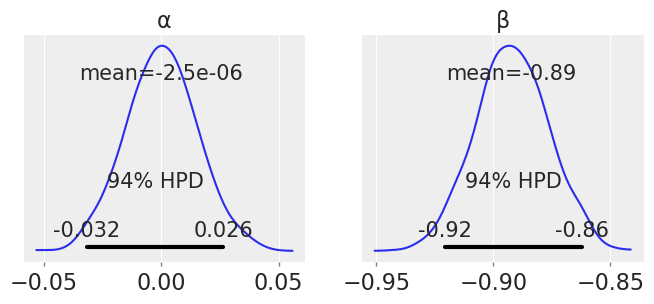

In [23]:
mlp_struct = ar.from_pymc3(trace=trace_mlp,
                           prior=prior_mlp,
                           posterior_predictive=post_mlp)

# run this locally only...
# mlp_struct.to_netcdf('./ModelResults/mbr_linear_pooled.nc')

_, ax = pl.subplots(ncols=2, figsize=(8, 3))
ar.plot_posterior(mlp_struct, var_names=['α', 'β'], ax=ax);

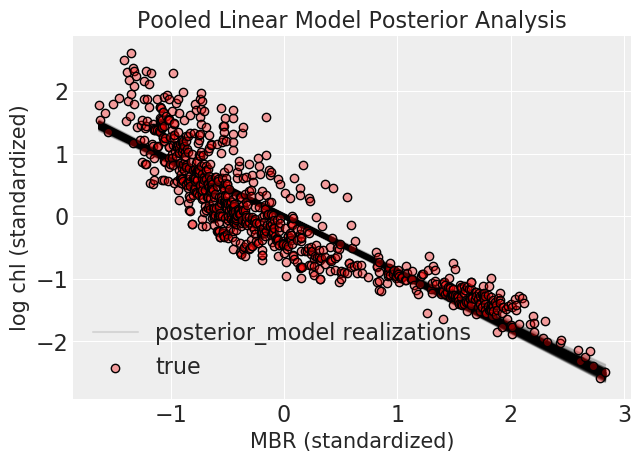

In [41]:
plot_posteriors(post_mlp, trace_mlp, x_train_s, y_train_s)

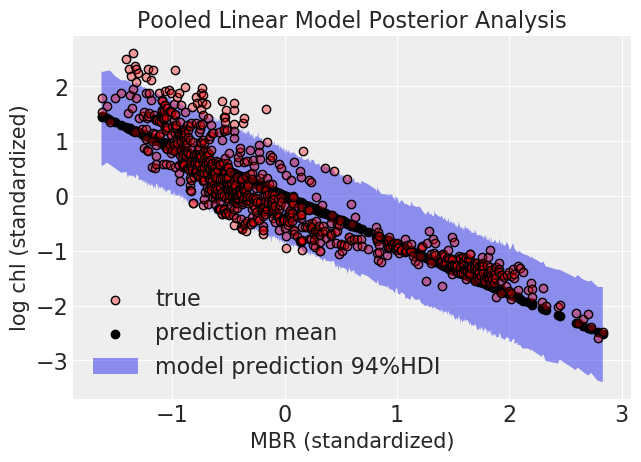

In [42]:
plot_posteriors(post_mlp, trace_mlp, x_train_s, y_train_s, model_centric=False)

---
[Back to Index](#TOP)

<a id='Model2'/>

## <u>Model 2: Hierarchical, Partially Pooled Model</u>
<br>

The use of MBR naturally separates the data into 3 groups, based on the blue band used in the numerator of MBR. Thus the model parameters, slope and intercept will be triplicates; slopes and intercepts will each have a common hyperprior. This structure makes the model hierarchical. I will use the MaxBlueBandIdx column, where '0', '1', '2', refer to Rrs443, Rrs490, Rrs510, respectively - column to index into the 3 groups.
As a reminder, the data looks as follows:

In [43]:
df_small_train.head()

,log_mxBlue2Gr,MaxBlueBandIdx,log_chlor_a
737,-0.081201,2,0.350248
1150,-0.118369,2,0.952017
1408,0.705471,0,-0.815791
1401,0.628335,0,-0.770216
3833,-0.022982,2,-0.171340


In [44]:
# extracting group index
mbr_train_idx = df_small_train.MaxBlueBandIdx
mbr_test_idx = df_small_test.MaxBlueBandIdx

### Model Development

In [45]:
with pm.Model() as mbr_lin_hier:

    gp_idx = shared(np.asarray(mbr_train_idx))
    x_shared = shared(np.asarray(x_train_s))
    hyper_α_μ = pm.Normal('hyper_α_μ', 0, .1)
    hyper_α_σ = pm.HalfCauchy('hyper_α_σ', 0.1)
    hyper_β_μ = pm.Normal('hyper_β_μ', 0, 0.1)
    hyper_β_σ = pm.HalfCauchy('hyper_β_σ', 0.1)
    β = pm.Normal('β', mu=hyper_β_μ, sd=hyper_β_σ, shape=3)
    α = pm.Normal('α', mu=hyper_α_μ, sd=hyper_α_σ, shape=3)
    μ = α[(gp_idx,)] + β[(gp_idx,)] * x_shared
    σ = pm.Exponential('σ', 1)
    likelihood = pm.Normal('likelihood', mu=μ, sd=σ, observed=y_train_s)

In [46]:
render = pm.model_to_graphviz(mbr_lin_hier)
render.render('mdl2', directory='./resources/', format='png');

<img src='./resources/mdl2.png?:1' />

### Assessing Priors with Prior Predictive Simulation

In [47]:
with mbr_lin_hier:
    prior_mlh = pm.sample_prior_predictive()

In [48]:
labels = ['Rrs443', 'Rrs489', 'Rrs510']

def plot_prior_hier(prior_predictive, X_s, y_s, mbr_idx):
    tab10 = cm.get_cmap('tab10')(np.linspace(0, 1, 10))
    tab10[:,-1] = 0.35
    c = tab10[mbr_train_idx]
    l = tab10[:3]
    c[:, -1] = 0.35
    l[:, -1] = 0.05
    pl.figure(figsize=(8,6))
    for i in range(3):
        xi = X_s[mbr_idx==i][None, :]
        yi = y_s[mbr_idx==i]
        ci = c[mbr_idx==i]
        li = l[i]
        ai = prior_predictive['α'][:, i][:, None]
        bi = prior_predictive['β'][:, i][:, None]
        prior_realizations = ai + bi * xi
        pl.scatter(xi, yi, c=ci, edgecolor='k', 
                   label=labels[i], zorder=3)
        pl.plot(xi.T, prior_realizations[0], c=l[i], 
                label=f' model prior ({labels[i]})', alpha=0.1)
        pl.plot(xi.T, prior_realizations[10:].T, c=l[i],)
    pl.ylim(-3.3, 3.3)
    leg = pl.legend(ncol=2, facecolor='white', framealpha=1,
                   loc='lower left')
    for l_ in leg.get_lines():
        l_.set_alpha(1)

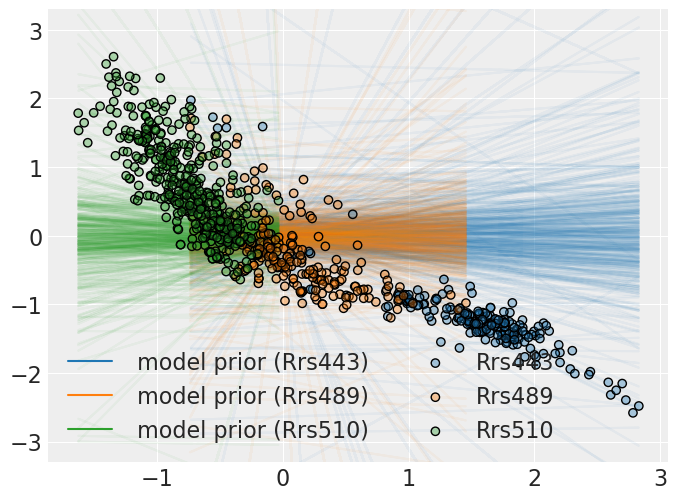

In [49]:
plot_prior_hier(prior_mlh, x_train_s, y_train_s, mbr_train_idx)

### Model Fitting & Posterior Evaluation

In [50]:
n_samples = 2000
with mbr_lin_hier:
    trace_mlh = pm.sample(n_samples, tune=1000)
    post_mlh = pm.sample_posterior_predictive(trace_mlh)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, α, β, hyper_β_σ, hyper_β_μ, hyper_α_σ, hyper_α_μ]
100%|██████████| 4000/4000 [00:03<00:00, 1046.96it/s]


In [51]:
## Plot Posterior Analysis
def plot_posterior_hier(X_s, y_s, trace, mbr_idx):
    n_iters = n_samples * trace.nchains
    scatter_alpha = 0.3
    line_alpha = 0.01
    tab10 = cm.get_cmap('tab10')(np.linspace(0, 1, 10))
    tab10[:,-1] = 0.35
    c = tab10[mbr_train_idx]
    l = tab10[:3]
    c[:, -1] = 0.35
    l[:, -1] = 0.05
    pl.figure(figsize=(8,6))
    for i in range(3):
        xi = X_s[mbr_idx==i][None, :]
        yi = y_s[mbr_idx==i]
        ci = c[mbr_idx==i]
        ci[:, -1] = scatter_alpha
        li = l[i]
        li[-1] = line_alpha
        ai = trace['α'][:, i][:, None]
        bi = trace['β'][:, i][:, None]
        post_realizations = ai + bi * xi
        choice_idx = np.random.choice(np.arange(n_iters, dtype='int'), 200, replace=False)
        pl.scatter(xi, yi, c=ci, edgecolor='k', 
                   label=f'obs. {labels[i]}',
                  )
        pl.plot(xi.T, post_realizations[0], c=li, 
                label=f' model fit ({labels[i]})', alpha=0.1)
        pl.plot(xi.T, post_realizations[choice_idx].T, c=li,)
    pl.ylim(-3.3, 3.3)
    leg = pl.legend(ncol=2, facecolor='white', framealpha=1,
                   loc='lower left')
    for l_ in leg.get_lines():
        l_.set_alpha(1)
    pl.ylabel('log chl (standardized)')
    pl.xlabel('MBR (standardized)')

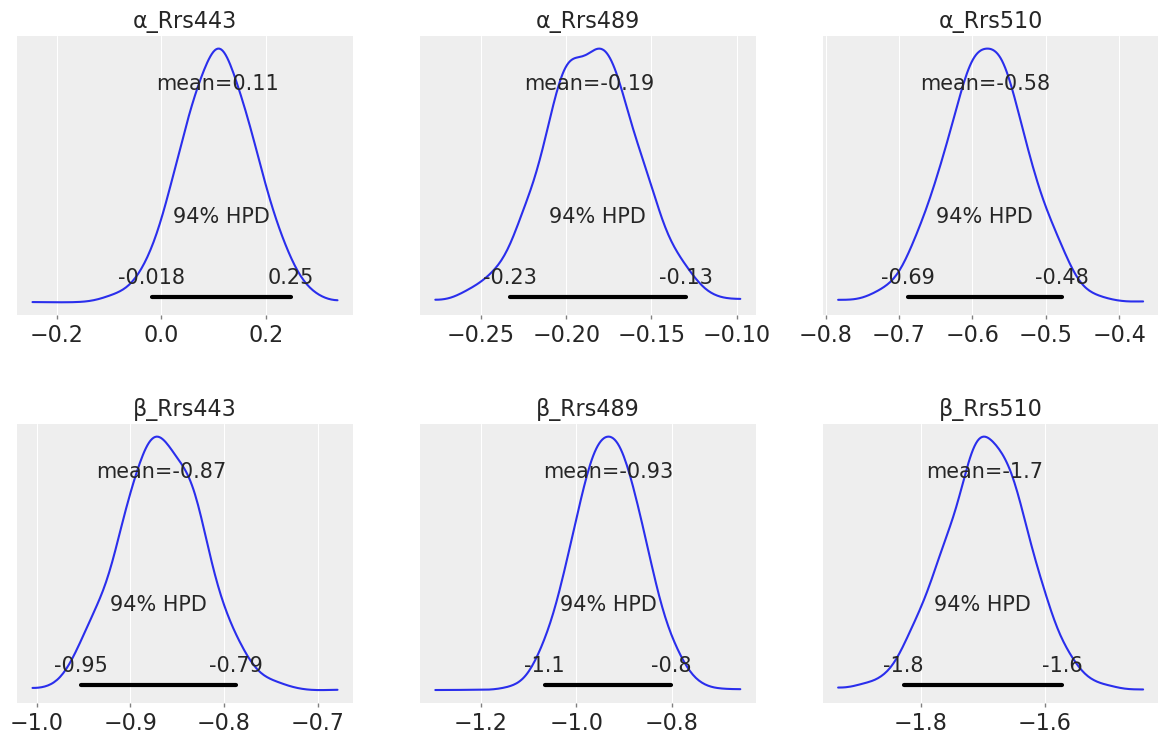

In [52]:
mlh_struct = ar.from_pymc3(trace=trace_mlh,
                           prior=prior_mlh,
                           posterior_predictive=post_mlh)

# run this locally only
# mlh_struct.to_netcdf('./ModelResults/mbr_linear_hier.nc')

f, axs = pl.subplots(ncols=3, nrows=2,figsize=(12, 8))
ar.plot_posterior(mlh_struct, var_names=['α', 'β'], ax=axs);
f.tight_layout()
for ax, lbl in zip(axs.ravel(), np.tile(labels, 2)):
    ax.set_title(f'{ax.get_title()[0]}_{lbl}')

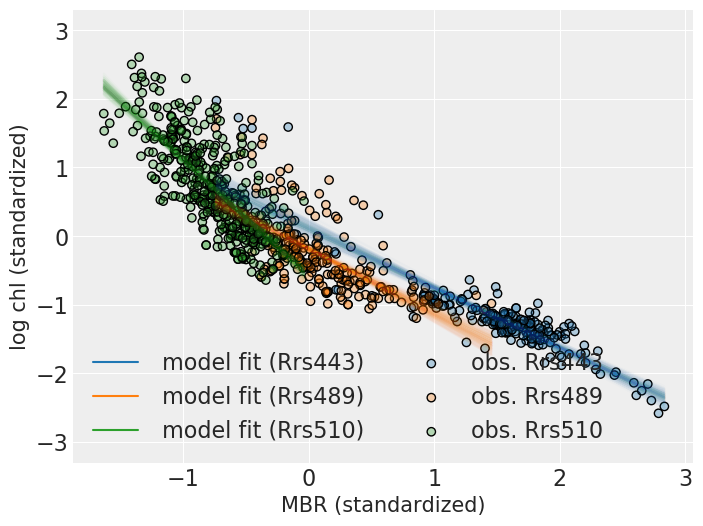

In [53]:
plot_posterior_hier(x_train_s, y_train_s, trace_mlh, mbr_train_idx)

---
[Back to Index](#TOP)

<a id="Model3"/>

## Model 3: <u>OC4-type \\(4^{th}\\) degree polynomial regression</u>


In [54]:
x_train_s_poly = np.c_[x_train_s, np.power(x_train_s, 2), 
                       np.power(x_train_s, 3), np.power(x_train_s, 4)]
x_test_s_poly = np.c_[x_test_s, np.power(x_test_s, 2),
                      np.power(x_test_s, 3), np.power(x_test_s, 4)]

### Model Development

In [55]:
with pm.Model() as mbr_oc4:
    data = pm.Data('data', x_train_s_poly)
    α = pm.Normal('α', mu=-0.1, sd=1)
    β = pm.Normal('β', mu=-1, sd=1, shape=4)
    σ = pm.Exponential('σ', 1)
    μ = α + pm.math.dot(data, β)
    likelihood = pm.Normal('likelihood', mu=μ, sd=σ, observed=y_train_s)

In [56]:
render = pm.model_to_graphviz(mbr_oc4)
render.render('mdl3', directory='./resources/', format='png');

<img src='./resources/mdl3.png'/>

### Assessing Priors with Prior Predictive Simulation

In [58]:
with mbr_oc4:
    prior_oc4 = pm.sample_prior_predictive()    

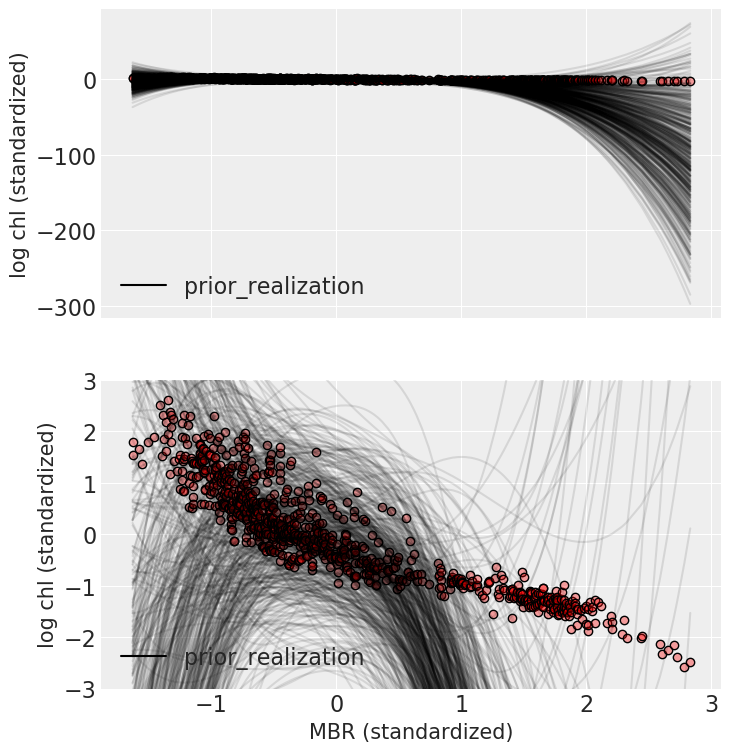

In [59]:
def plot_prior_oc4():
    f, axs = pl.subplots(nrows=2, figsize=(8, 9), sharex=True)
    x_idx = np.argsort(x_train_s)
    prior_realizations = np.dot(x_train_s_poly,
                                prior_oc4['β'].T) + prior_oc4['α'][None,:]
    for axi in axs:
        axi.scatter(x_train_s[x_idx], y_train_s[x_idx], c= [[1, 0, 0, 0.35]],
                   edgecolor='k')
        axi.plot(x_train_s[x_idx], prior_realizations[x_idx, 0], color='k', alpha=0.1,
               label='prior_realization')
        axi.plot(x_train_s[x_idx], prior_realizations[x_idx, 1:], color='k', alpha=0.1);
        leg = axi.legend(ncol=2, facecolor='white', framealpha=1,
                       loc='lower left')
        for l_ in leg.get_lines():
            l_.set_alpha(1)
        axi.set_ylabel('log chl (standardized)')
    axi.set_xlabel('MBR (standardized)');
    axi.set_ylim(-3, 3);
plot_prior_oc4()

### Model Fitting & Posterior Evaluation

In [61]:
n_samples = 2000
with mbr_oc4:
    trace_oc4 = pm.sample(n_samples, tune=2000, cores=1, chains=2)
    post_oc4 = pm.sample_posterior_predictive(trace_oc4)  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, β, α]
100%|██████████| 4000/4000 [00:03<00:00, 1117.55it/s]


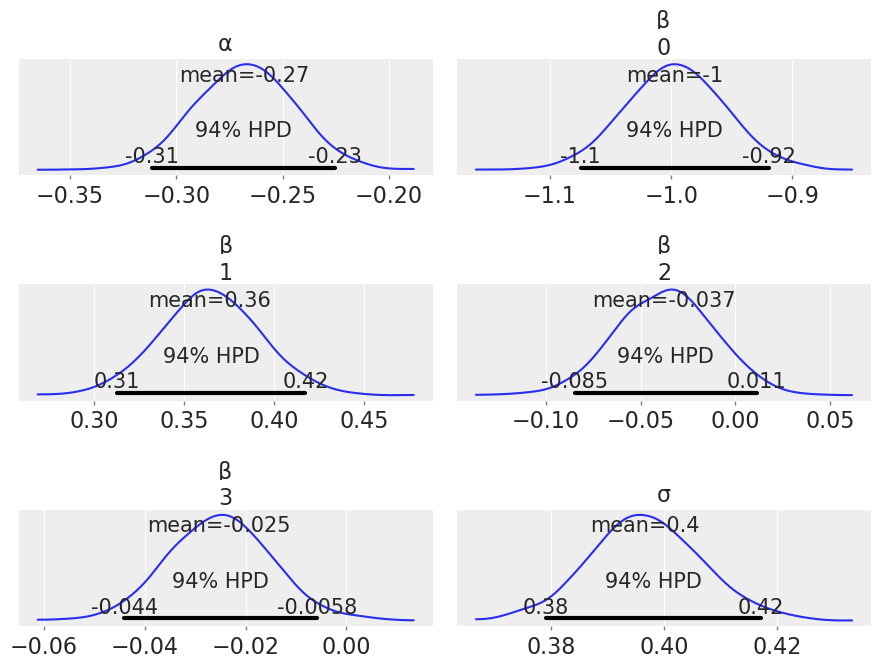

In [62]:
oc4_struct = ar.from_pymc3(trace=trace_oc4,
                           prior=prior_oc4,
                           posterior_predictive=post_oc4)

# run this locally only.
# oc4_struct.to_netcdf('./ModelResults/oc4.nc')

f, axs = pl.subplots(3 ,2, figsize=(9, 7))
ar.plot_posterior(trace_oc4, ax=axs);
f.tight_layout()

---
[Back to Index](#TOP)

<a id="Model4"/>

## Model 4: <u>PCA-Based Linear Regression</u>

Here, all 6 bands are used, rotated using a PCA projection before being used as model input. None of the PCs are discarded.
PCA conversion was done [here](./Step-2-2-Feature-Engineering_PCA.ipynb#std_pca).

Loading train and test sets:

In [64]:
df_train_pca_s = pd.read_feather('./data/df_train_s_2019-09-04 13:38:04.339598.feather')
df_test_pca_s = pd.read_feather('./data/df_test_s_2019-09-04 13:38:04.341658.feather')

In [65]:
df_train_pca_s.filter(regex='(PC.)', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841 entries, 0 to 840
Data columns (total 6 columns):
PC_1_s    841 non-null float64
PC_2_s    841 non-null float64
PC_3_s    841 non-null float64
PC_4_s    841 non-null float64
PC_5_s    841 non-null float64
PC_6_s    841 non-null float64
dtypes: float64(6)
memory usage: 39.5 KB


In [66]:
x_train_pca_s = df_train_pca_s.filter(regex='(PC.)', axis=1).values
x_test_pca_s = df_test_pca_s.filter(regex='(PC.)', axis=1).values

### Model Development

In [67]:
with pm.Model() as m_pca:
    pca_data = pm.Data('pca_data', x_train_pca_s)
    α = pm.Normal('α', 0, sd=1)
    β = pm.Normal('β', 0, sd=1, shape=6)
    σ = pm.Exponential('σ', 1)
    μ = pm.math.dot(pca_data, β) + α
    likelihood = pm.Normal('likelihood', mu=μ, sd=σ, observed=y_train_s)

In [68]:
render = pm.model_to_graphviz(m_pca)
render.render('mdl4', directory='./resources/', format='png');

<img src='./resources/mdl4.png' />

In [69]:
with m_pca:
    prior_pca = pm.sample_prior_predictive(model=m_pca)

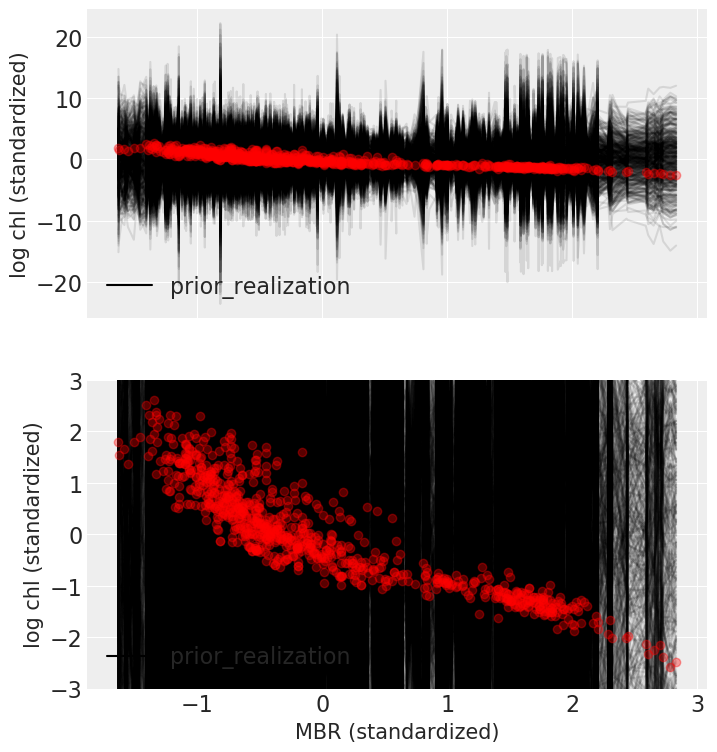

In [70]:
def plot_pca_prior_sim():
    f, axs = pl.subplots(nrows=2, figsize=(8, 9), sharex=True)
    x_idx = np.argsort(x_train_s)
    prior_realizations = np.dot(x_train_pca_s,
                                prior_pca['β'].T) + prior_pca['α'][None,:]
    for axi in axs:
        axi.scatter(x_train_s[x_idx], y_train_s[x_idx], c= [[1, 0, 0, 0.35]],
                   zorder=3)
        axi.plot(x_train_s[x_idx], prior_realizations[x_idx, 0], color='k', alpha=0.1,
               label='prior_realization')
        axi.plot(x_train_s[x_idx], prior_realizations[x_idx, 1:], color='k', alpha=0.1);
        leg = axi.legend(ncol=2, facecolor='white', framealpha=1,
                       loc='lower left')
        for l_ in leg.get_lines():
            l_.set_alpha(1)
        axi.set_ylabel('log chl (standardized)')
    axi.set_xlabel('MBR (standardized)');
    axi.set_ylim(-3, 3);
plot_pca_prior_sim()

### Model Fitting & Posterior Evaluation

In [71]:
n_samples = 2000
with m_pca:
    trace_pca = pm.sample(n_samples, tune=1000)
    post_pca = pm.sample_posterior_predictive(trace_pca)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β, α]
100%|██████████| 4000/4000 [00:06<00:00, 652.14it/s]


In [72]:
pca_struct = ar.from_pymc3(trace=trace_pca,
                           prior=prior_pca,
                           posterior_predictive=post_pca)

# run this locally only
# pca_struct.to_netcdf('./ModelResults/pca.nc')

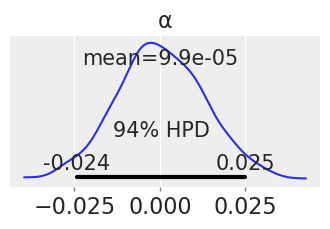

In [73]:
_, ax = pl.subplots(figsize=(4, 2))
ar.plot_posterior(trace_pca, var_names='α', ax=ax);

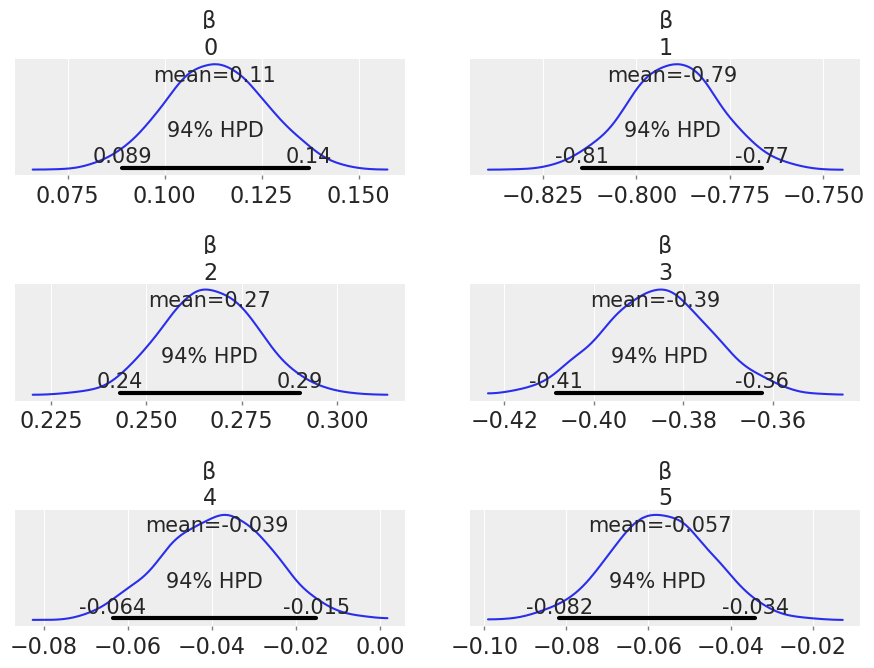

In [74]:
f, axs = pl.subplots(3 ,2, figsize=(9, 7))
ar.plot_posterior(trace_pca, ax=axs, var_names=['β']);
f.tight_layout();

---
[Back to Index](#TOP)

<a id='ModelComp'/>

## <u>Model Skill Comparison</u>

### Parameter Pairwise Plot: Assessing Information Utilization

#### Model 1: Linear Regression

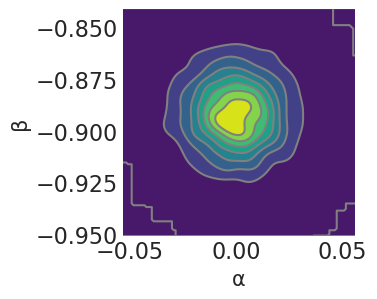

In [94]:
f, axs = pl.subplots(figsize=(3, 3))
ar.plot_pair(mlp_struct, kind='kde', divergences=True,
            var_names=['α', 'β'], ax=axs);

#### Model 2: Hierarchical LR

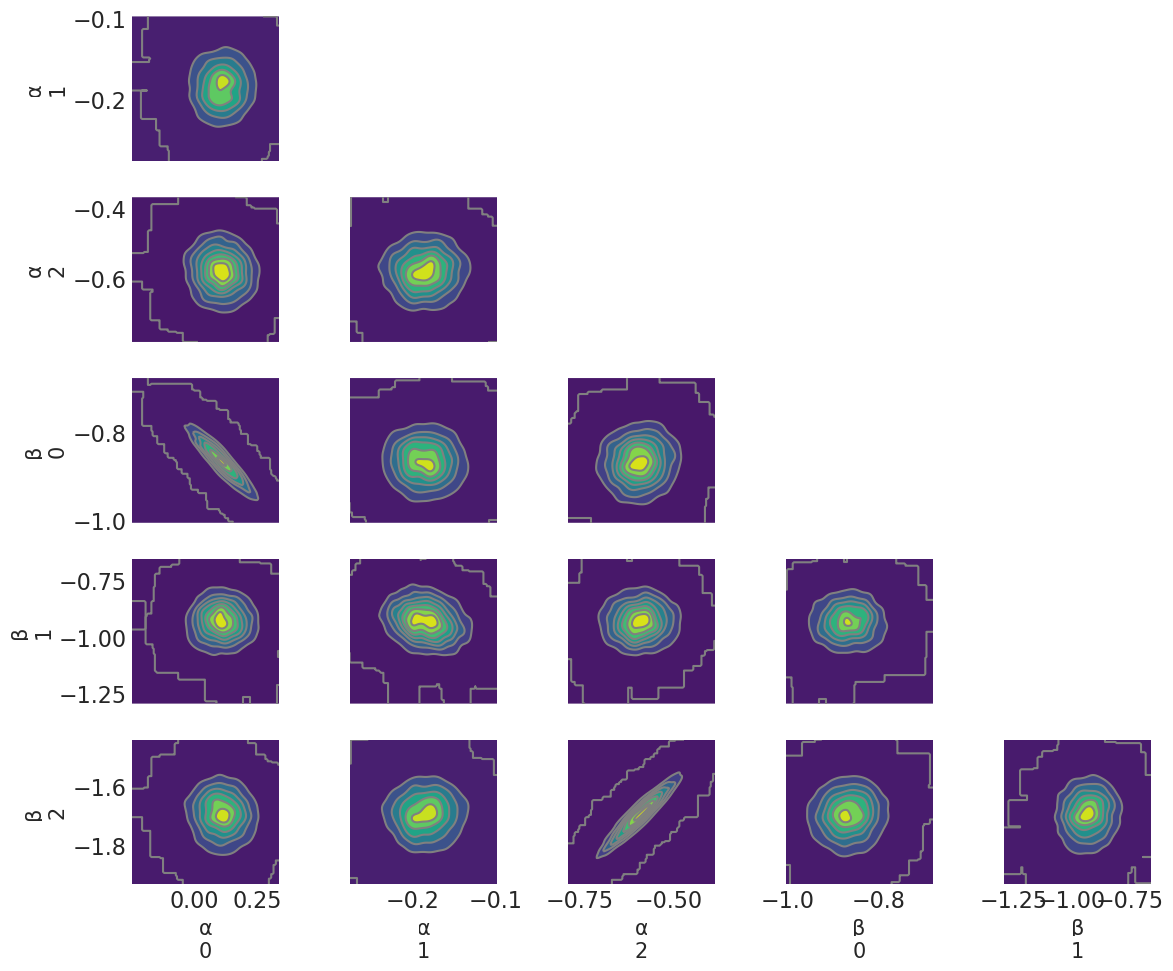

In [97]:
f, axs = pl.subplots(ncols=5, nrows=5, figsize=(12,10))
ar.plot_pair(mlh_struct, kind='kde', divergences=True,
            var_names=['α', 'β'], ax=axs);
f.tight_layout()

#### Model 3: Polynomial Regression

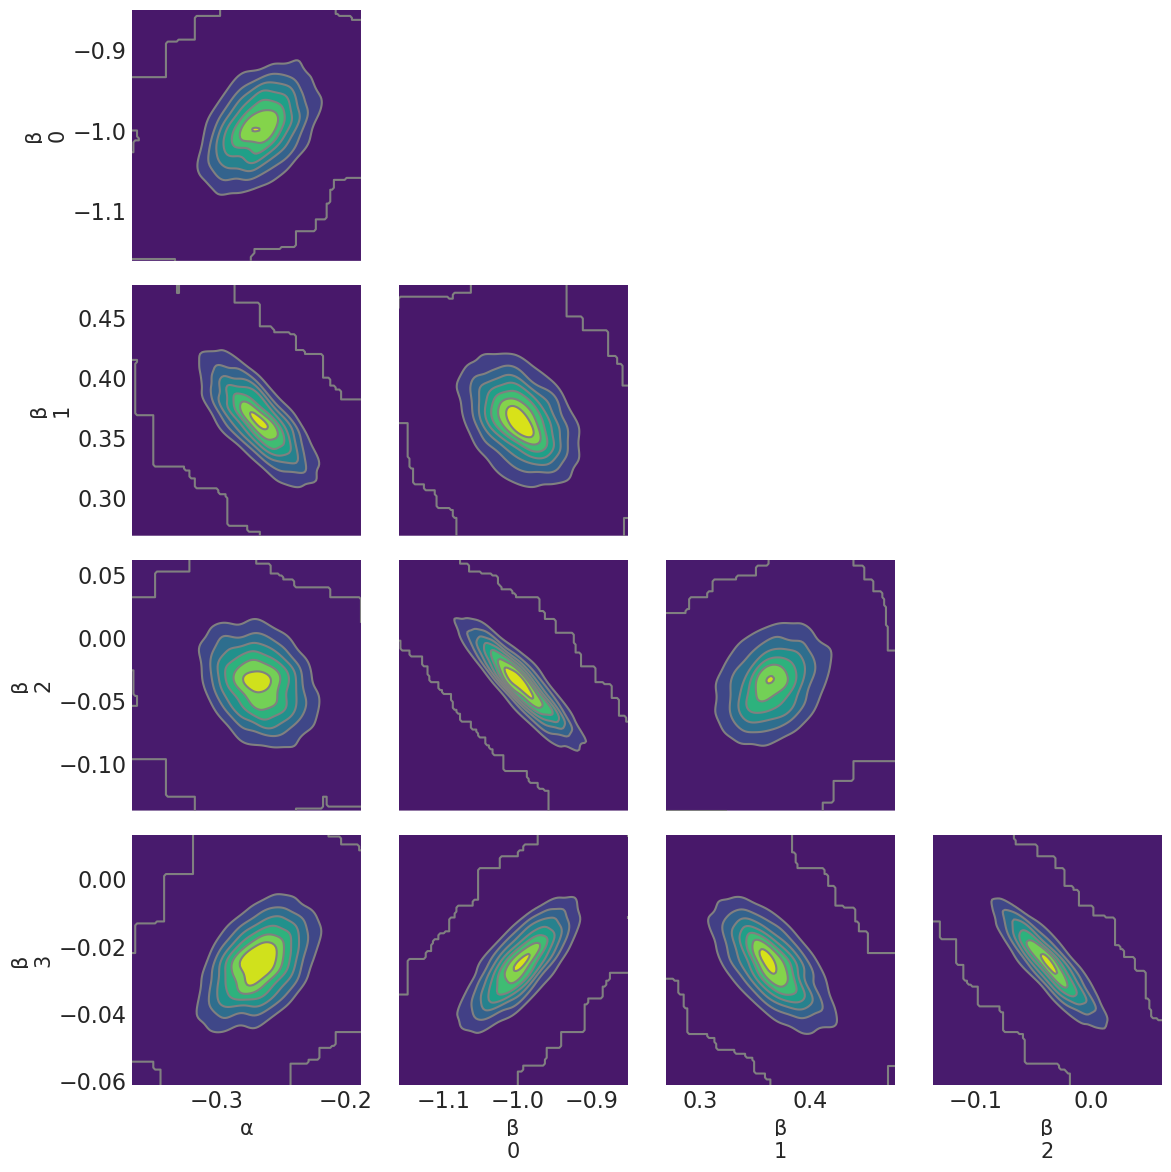

In [92]:
f, axs = pl.subplots(ncols=4, nrows=4, figsize=(12,12))
ar.plot_pair(oc4_struct, kind='kde', divergences=True,
            var_names=['α', 'β'], ax=axs);
f.tight_layout()

#### Model 4: PCA-Based LR

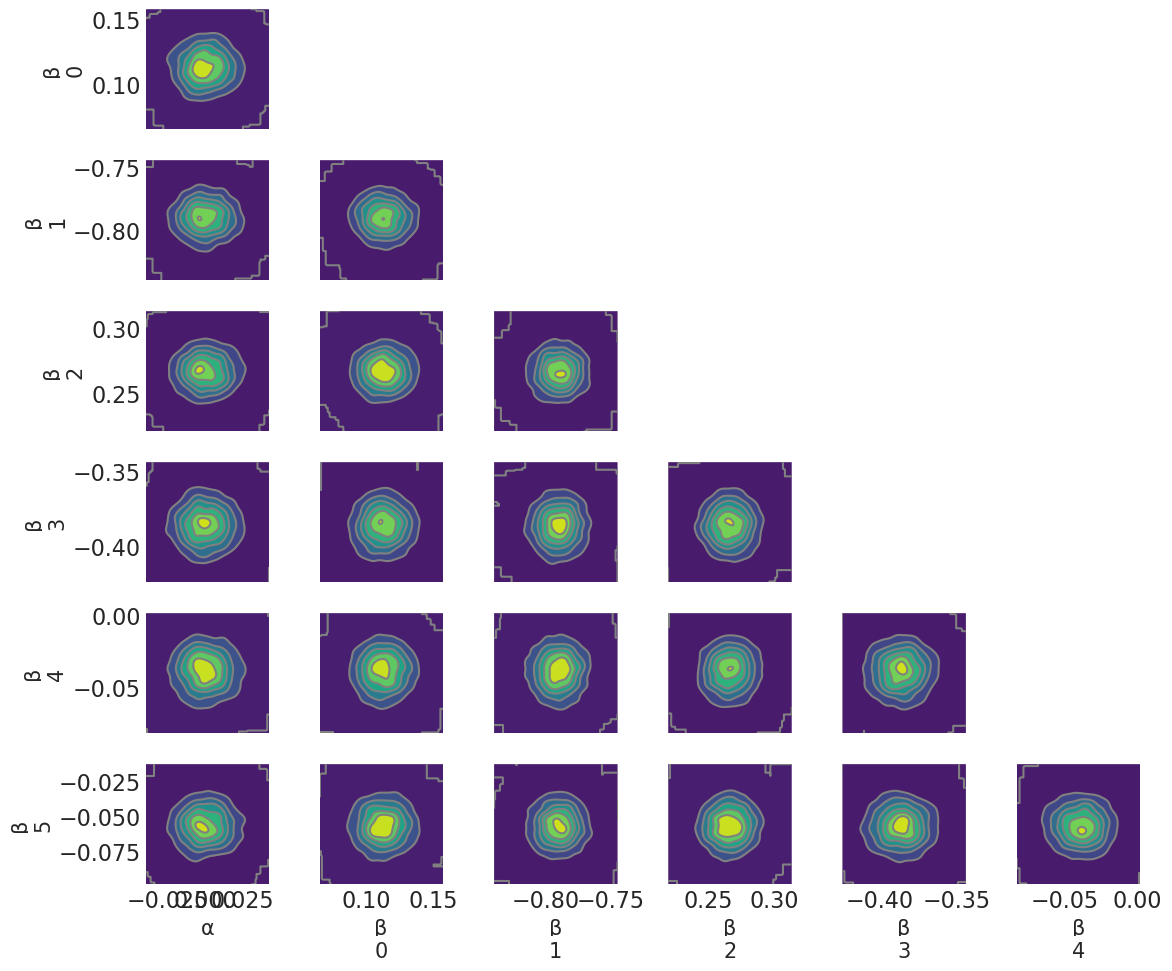

In [99]:
f, axs = pl.subplots(ncols=6, nrows=6, figsize=(12,10))
ar.plot_pair(pca_struct, kind='kde', divergences=True,
            var_names=['α', 'β'], ax=axs);
f.tight_layout();

---
[Back to Index](#TOP)

<a id='Comp-IC'/>

### Comparison via WAIC/PSIS-LOOCV

\\(\rightarrow\\)Estimate model skill on out-of-sample data<br>

\\(\rightarrow\\)Useful for model comparison/selection/ensemble averaging

In [103]:
inference_dict = {'MBR Lin. Reg': mlp_struct, 'MBR Hier. LR.': mlh_struct, 
           'Poly Reg.': oc4_struct, 'PCA Lin. Reg.': pca_struct}
df_waic = ar.compare(inference_dict)
df_waic

/Users/ekarakoy/anaconda3/envs/bayes_chl/lib/python3.7/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
PCA Lin. Reg.,0,732.384,9.11185,0,0.997067,42.8934,0,True,deviance
Poly Reg.,1,836.1,5.98235,103.716,0.00293313,51.0326,35.4574,False,deviance
MBR Hier. LR.,2,855.704,9.61885,123.32,2.0115e-07,52.9525,34.8473,True,deviance
MBR Lin. Reg,3,1055.63,2.85889,323.244,2.58365e-44,47.4202,38.3319,False,deviance


In [104]:
df_loo = ar.compare(inference_dict, ic='loo')
df_loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
PCA Lin. Reg.,0,732.401,9.1202,0,0.996461,42.5663,0,False,deviance
Poly Reg.,1,836.139,6.00186,103.738,0.00322732,50.3736,35.4611,False,deviance
MBR Hier. LR.,2,855.743,9.63822,123.342,0.00031217,54.3164,34.8514,False,deviance
MBR Lin. Reg,3,1055.63,2.85911,323.228,1.23461e-43,49.4995,38.3341,False,deviance


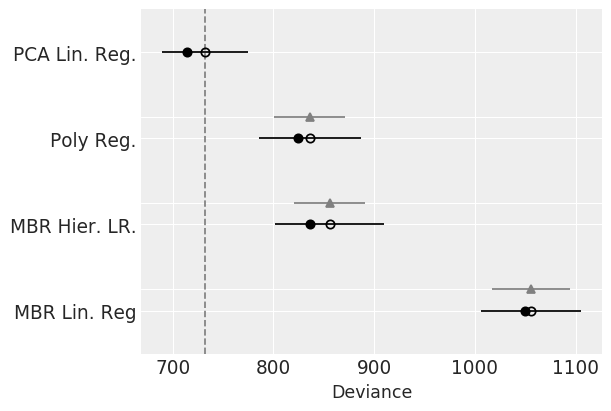

In [105]:
ar.plot_compare(df_loo);

### <u>Comparison via Out-of-Sample Testing</u>

#### Model 1: Linear Regression

In [106]:
with mbr_linear_pooled:
    # Switch out the observations and use `sample_posterior_predictive` to predict
    pm.set_data({'data': x_test_s})
    post_pred_mlp = pm.sample_posterior_predictive(trace_mlp, samples=500)

100%|██████████| 500/500 [00:00<00:00, 516.25it/s]


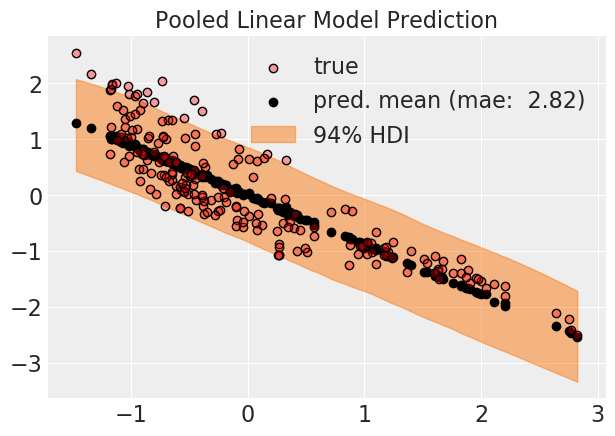

In [121]:
y_pred_s_lin = post_pred_mlp['likelihood']
mae_lin = MAE(np.power(10, sc_y.inverse_transform(y_test_s)), 
              np.power(10, sc_y.inverse_transform(y_pred_s_lin)).mean(axis=0))

def plot_oos_ppc_lr():
    pl.title('Pooled Linear Model Prediction')
    plot_data(x_test_s, y_test_s, )
    pl.scatter(x_test_s, y_pred_s_lin.mean(axis=0), 
               label=f'pred. mean (mae: {mae_lin: .2f})', color='k',
               zorder=2)
    ar.plot_hpd(x_test_s, y_pred_s_lin, fill_kwargs=dict(label='94% HDI'))
    pl.legend();
plot_oos_ppc_lr()

#### Model 2: Hierarchical Linear Regression

In [111]:
with mbr_lin_hier:
    # Switch out the observations and use `sample_posterior_predictive` to predict
    gp_idx.set_value(mbr_test_idx)
    x_shared.set_value(x_test_s)
    post_pred_mlh = pm.sample_posterior_predictive(trace_mlh, samples=500)

100%|██████████| 500/500 [00:01<00:00, 497.60it/s]


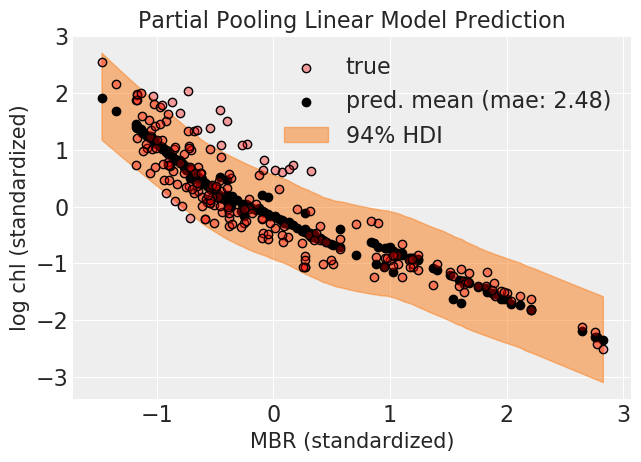

In [120]:
y_pred_s_mlh = post_pred_mlh['likelihood']
mae_mlh = MAE(np.power(10, sc_y.inverse_transform(y_test_s)), 
              np.power(10, sc_y.inverse_transform(y_pred_s_mlh)).mean(axis=0))
def plot_oos_ppc_hlr():
    pl.title('Partial Pooling Linear Model Prediction')
    plot_data(x_test_s, y_test_s, label='true')
    #pl.scatter(x_test_s, y_test_s, label='true')
    pl.scatter(x_test_s, y_pred_s_mlh.mean(axis=0), 
               label=f'pred. mean (mae: {mae_mlh:.2f})', color='k', zorder=2)
    ar.plot_hpd(x_test_s, y_pred_s_mlh, fill_kwargs=dict(label='94% HDI'))
    pl.legend();
    pl.ylabel('log chl (standardized)')
    pl.xlabel('MBR (standardized)');
plot_oos_ppc_hlr()

#### Model 3: Polynomial Regression

In [113]:
with mbr_oc4:
    # Switch out the observations and use `sample_posterior_predictive` to predict
    data.set_value(x_test_s_poly)
    post_pred_oc4 = pm.sample_posterior_predictive(trace_oc4, samples=500)

100%|██████████| 500/500 [00:00<00:00, 506.36it/s]


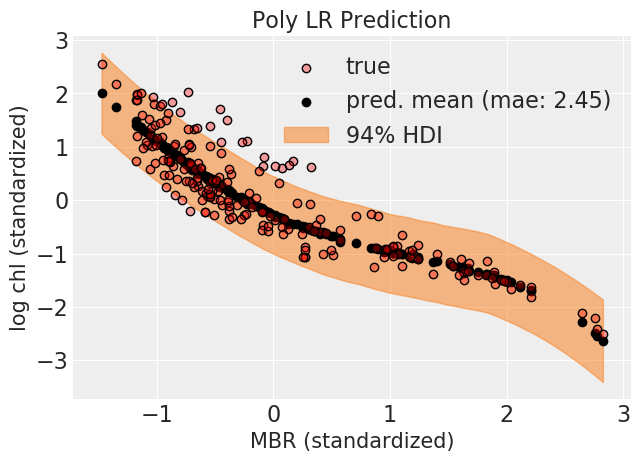

In [119]:
y_pred_s_oc4 = post_pred_oc4['likelihood']
mae_oc4 = MAE(np.power(10, sc_y.inverse_transform(y_test_s)),
              np.power(10, sc_y.inverse_transform(y_pred_s_oc4)).mean(axis=0))
def plot_oos_ppc_oc4():
    pl.title('Poly LR Prediction')
    plot_data(x_test_s, y_test_s, label='true')
    #pl.scatter(x_test_s, y_test_s, label='true')
    pl.scatter(x_test_s, y_pred_s_oc4.mean(axis=0), 
               label=f'pred. mean (mae: {mae_oc4:.2f})', color='k', zorder=2)
    ar.plot_hpd(x_test_s, y_pred_s_oc4, fill_kwargs=dict(label='94% HDI'))
    pl.legend();
    pl.ylabel('log chl (standardized)')
    pl.xlabel('MBR (standardized)');
plot_oos_ppc_oc4()

#### Model 4: PCA-Based Linear Regression

In [116]:
with m_pca:
    pca_data.set_value(x_test_pca_s)
    post_pred_pca = pm.sample_posterior_predictive(trace_pca, samples=500)

100%|██████████| 500/500 [00:01<00:00, 486.25it/s]


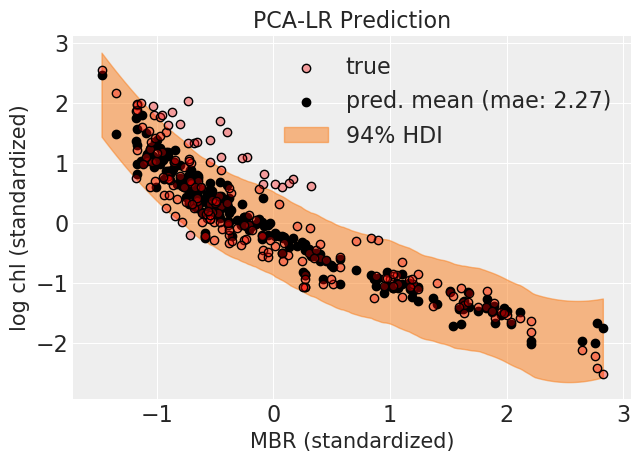

In [123]:
y_pred_s_pca= post_pred_pca['likelihood']
mae_pca = MAE(np.power(10, sc_y.inverse_transform(y_test_s)), 
                  np.power(10, sc_y.inverse_transform(y_pred_s_pca)).mean(axis=0))
def plot_oos_ppc_pca():
    pl.title('PCA-LR Prediction')
    plot_data(x_test_s, y_test_s, label='true')
    #pl.scatter(x_test_s, y_test_s, label='true')
    pl.scatter(x_test_s, y_pred_s_pca.mean(axis=0), 
               label=f'pred. mean (mae: {mae_pca:.2f})', color='k', zorder=2)
    ar.plot_hpd(x_test_s, y_pred_s_pca, fill_kwargs=dict(label='94% HDI'))
    pl.legend();
    pl.ylabel('log chl (standardized)')
    pl.xlabel('MBR (standardized)');
plot_oos_ppc_pca()

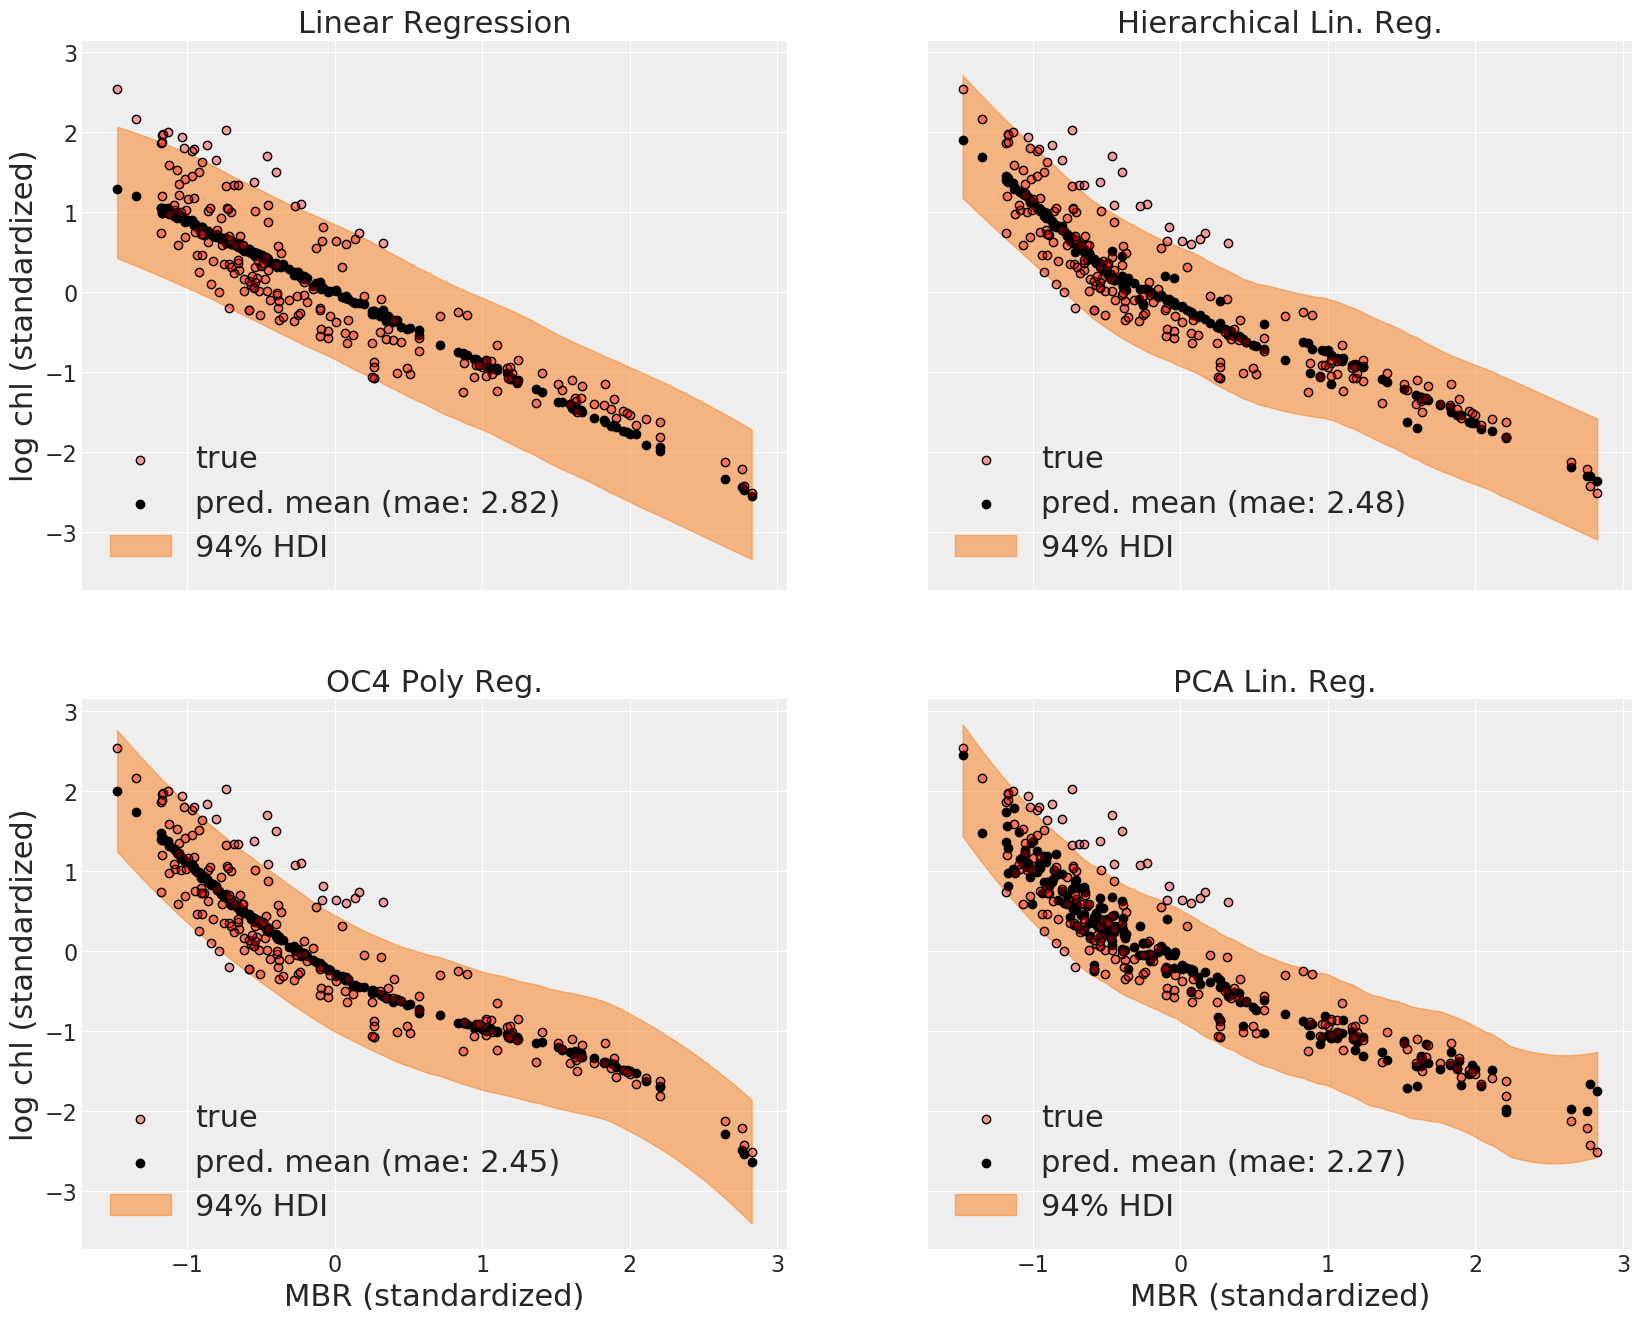

In [124]:
def plot_all_oos_ppc():
    f, axs = pl.subplots(nrows=2, ncols=2, figsize=(20, 16), sharey=True, sharex=True)
    mae_list = [mae_lin, mae_mlh, mae_oc4, mae_pca]
    y_pred_list = [y_pred_s_lin, y_pred_s_mlh, y_pred_s_oc4, y_pred_s_pca]
    titles = ['Linear Regression', 'Hierarchical Lin. Reg.',
              'OC4 Poly Reg.','PCA Lin. Reg. ']
    for i, (ax, mae, y_pred, ttl) in enumerate(zip(axs.ravel(), mae_list, 
                                                   y_pred_list, titles)):
        ax.set_title(ttl, fontsize=22)
        plot_data(x_test_s, y_test_s, label='true', ax=ax)
        ax.scatter(x_test_s, y_pred.mean(axis=0), 
                   label=f'pred. mean (mae: {mae:.2f})', color='k', zorder=2)
        ax = ar.plot_hpd(x_test_s, y_pred, fill_kwargs=dict(label='94% HDI'), ax=ax)
        ax.legend(fontsize=22, loc='lower left');
        if i%2==0:
            ax.set_ylabel('log chl (standardized)', fontsize=22)
        if i>1:
            ax.set_xlabel('MBR (standardized)', fontsize=22);
plot_all_oos_ppc()

[Back to Index](#TOP)

---
End of this Notebook